# Stima {#sec-rasch-estimation}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
here::here("code", "_common.R") |>
    source()

# Load packages
if (!requireNamespace("pacman")) install.packages("pacman")
pacman::p_load(
    grid, latex2exp, mirt, TAM, ggmirt, cmdstanr, posterior,
    rstan, tidyr, psych, rsvg, effectsize
)

## Introduzione

Per applicare il modello di Rasch nella ricerca pratica, è fondamentale sapere come stimare i suoi parametri utilizzando dati empirici. In questa sezione, verranno presentati diversi approcci per stimare i parametri del modello di Rasch a partire dai dati dei test osservati. Tutti questi metodi permettono di stimare sia i parametri degli item che quelli delle persone, ma differiscono nel modo in cui lo fanno. 

Due approcci – la massima verosimiglianza congiunta e l'inferenza bayesiana – stimano contemporaneamente i parametri degli item e delle persone. Gli altri due – la massima verosimiglianza condizionale e la massima verosimiglianza marginale – separano le stime, con i parametri delle persone calcolati in un secondo passaggio.

## La Funzione di Verosimiglianza

La stima dei parametri nel modello di Rasch si basa sulla funzione di verosimiglianza, che esprime la probabilità di osservare i dati disponibili dato un insieme di parametri del modello ancora sconosciuti. Nel modello di Rasch, $U_{pi}$ rappresenta la risposta (corretta o errata) fornita dalla persona $p$ all’item $i$, dove una risposta corretta è codificata come 1, mentre una risposta errata è codificata come 0. La probabilità condizionale che la persona $p$ dia una risposta specifica $u_{pi}$ all’item $i$, data la propria abilità $\theta_p$ e la difficoltà dell’item $\beta_i$, è data dalla seguente formula:

$$
L_{upi}(\theta_p, \beta_i) = \text{Pr}(U_{pi} = u_{pi} | \theta_p, \beta_i) = \frac{\exp\{u_{pi} \cdot (\theta_p - \beta_i)\}}{1 + \exp(\theta_p - \beta_i)}.
$$ {#eq-rasch-likelihood}

Questa espressione calcola la probabilità di osservare la risposta specifica $u_{pi}$, in funzione della differenza tra l'abilità della persona ($\theta_p$) e la difficoltà dell'item ($\beta_i$). Se $\theta_p > \beta_i$, la probabilità di una risposta corretta ($u_{pi} = 1$) sarà elevata; al contrario, se $\theta_p < \beta_i$, la probabilità di una risposta corretta sarà bassa.

Per ottenere la verosimiglianza complessiva delle risposte fornite da una persona $p$ a tutti gli item del test (da $i = 1$ a $I$), si moltiplicano le probabilità condizionali di tutte le sue risposte. La funzione di verosimiglianza totale è espressa come:

$$
L_{up}(\theta_p, \beta) = \prod_{i=1}^{I} \frac{\exp\{u_{pi} \cdot (\theta_p - \beta_i)\}}{1 + \exp(\theta_p - \beta_i)},
$$

che può essere riscritta per maggiore chiarezza come:

$$
L_{up}(\theta_p, \beta) = \frac{\exp(r_p \cdot \theta_p - \sum_{i=1}^{I} u_{pi} \cdot \beta_i)}{\prod_{i=1}^{I} [1 + \exp(\theta_p - \beta_i)]}, \tag{1}
$$

dove $r_p = \sum_{i=1}^{I} u_{pi}$ è il punteggio grezzo (numero di risposte corrette) della persona $p$.

### Importanza della Funzione di Verosimiglianza

L’@eq-rasch-likelihood rappresenta la base comune per tutti i metodi di stima dei parametri nel modello di Rasch. Tuttavia, il metodo scelto per stimare i parametri influenzerà il modo in cui l'abilità delle persone ($\theta_p$) e la difficoltà degli item ($\beta_i$) vengono calcolate e interpretate:

- **Stima simultanea**: Alcuni metodi, come la massima verosimiglianza congiunta e l'inferenza bayesiana, stimano simultaneamente $\theta_p$ e $\beta_i$.
- **Stima separata**: Altri metodi, come la massima verosimiglianza condizionale e la massima verosimiglianza marginale, stimano $\beta_i$ in un primo passaggio, per poi derivare $\theta_p$.

Ogni approccio introduce assunzioni specifiche che influenzano le proprietà delle stime e la loro applicabilità in diversi contesti.

## Stima dei Parametri nel Modello di Rasch

### Stima della Massima Verosimiglianza Congiunta

La **stima della massima verosimiglianza congiunta (JML)** mira a determinare simultaneamente i parametri delle persone ($\theta_p$) e degli item ($\beta_i$) che massimizzano la probabilità complessiva dei dati osservati, come descritto nella funzione di verosimiglianza del modello di Rasch. Questo approccio identifica il set di parametri più probabili che potrebbero aver generato il dataset analizzato.

**Punti di forza**:

- Metodo diretto e intuitivo, che utilizza tutta l'informazione disponibile nei dati osservati.

**Limitazioni**:

- **Stime inconsistenti**: Nonostante la semplicità del metodo, JML non garantisce stime consistenti dei parametri degli item, anche con campioni di grandi dimensioni. Questo limita la sua affidabilità, specialmente in contesti che richiedono alta precisione e robustezza nelle stime.
- **Bias intrinseco**: Le stime delle abilità ($\theta_p$) e delle difficoltà ($\beta_i$) possono essere influenzate l'una dall'altra, causando errori sistematici.

**Implementazione in R**:

- JML è implementato nel pacchetto **TAM**, attraverso la funzione `tam.jml()`. Sebbene disponibile, il suo utilizzo è sconsigliato in analisi avanzate o quando la consistenza delle stime è critica.

---

### Stima della Massima Verosimiglianza Condizionale

La **stima della massima verosimiglianza condizionale (CML)** affronta le limitazioni della JML separando la stima dei parametri degli item da quella delle persone. Questo approccio procede in due fasi:

1. **Stima dei parametri degli item**:

   - La CML utilizza le **statistiche sufficienti** delle persone (ad esempio, i punteggi grezzi $r_p = \sum u_{pi}$) per isolare i parametri degli item. In questa fase, le abilità delle persone ($\theta_p$) non sono direttamente considerate, evitando il bias congiunto.
   
2. **Stima dei parametri delle persone**:

   - Una volta stimati i parametri degli item ($\beta_i$), si procede alla stima delle abilità ($\theta_p$) basandosi sui dati individuali e sulle difficoltà stimate.

**Vantaggi**:

- Fornisce stime consistenti dei parametri degli item.
- Evita il problema del bias associato alla stima simultanea di JML.

**Limitazioni**:

- L'accuratezza dei parametri delle persone dipende dalla precisione delle stime degli item nella prima fase.

**Implementazione in R**:

- La CML è implementata nel pacchetto **eRm** tramite la funzione `RM()`, che consente di stimare i parametri degli item in modo robusto e separato.

---

### Stima della Massima Verosimiglianza Marginale

La **stima della massima verosimiglianza marginale (MML)** rappresenta un approccio avanzato che considera le abilità delle persone come una variabile casuale seguendo una distribuzione ipotizzata, tipicamente normale. Questo metodo differisce dalla CML trattando i parametri delle abilità ($\theta_p$) come effetti casuali anziché fissi, e li integra nella funzione di verosimiglianza complessiva.

#### **Come funziona**:
1. **Distribuzione marginale delle abilità**:

   - La MML assume che le abilità ($\theta_p$) siano distribuite nella popolazione secondo una distribuzione nota (ad esempio, una normale standard). Invece di stimare direttamente $\theta_p$, il metodo stima i parametri degli item ($\beta_i$) tenendo conto di questa distribuzione.

2. **Scoring individuale**:

   - Dopo aver stimato i parametri degli item, si calcolano i punteggi individuali ($\theta_p$) basandosi sulle risposte e sui parametri stimati.

#### **Vantaggi**:

- Produce stime più precise e realistiche dei parametri degli item rispetto alla JML.
- È particolarmente utile quando le abilità nella popolazione seguono una distribuzione continua e ipotizzabile.

#### **Limitazioni**:

- La validità delle stime dipende dalla correttezza dell'assunzione sulla distribuzione delle abilità ($\theta_p$).

#### **Implementazione in R**:

- La MML è supportata dai pacchetti **mirt** e **TAM**. Ad esempio:
  - Funzioni come `mirt()` in **mirt** permettono stime flessibili con distribuzioni marginali specificabili.
  - Anche **ltm** (sebbene non più attivamente sviluppato) offre strumenti per la stima marginale.

---

### Confronto tra i Metodi

| **Metodo**                  | **Caratteristiche principali**                                                                                        | **Pro**                                                              | **Contro**                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------|--------------------------------------------------------------|
| **JML (Massima Verosimiglianza Congiunta)** | Stima simultanea di $\theta_p$ e $\beta_i$.                                                              | Intuitivo e diretto.                                                 | Stime inconsistenti; bias congiunto.                        |
| **CML (Massima Verosimiglianza Condizionale)** | Stima separata in due fasi: prima $\beta_i$, poi $\theta_p$.                                              | Stime consistenti per $\beta_i$; evita il bias.                  | Dipende dall'accuratezza delle stime iniziali degli item.    |
| **MML (Massima Verosimiglianza Marginale)** | Integra una distribuzione marginale per $\theta_p$; tratta $\theta_p$ come effetti casuali.               | Stime realistiche e robuste; considera la distribuzione della popolazione. | Dipende dall'assunzione sulla distribuzione delle abilità.  |

In conclusione, ogni metodo presenta vantaggi e svantaggi che lo rendono più o meno adatto a specifici contesti di analisi. La **JML** è utile per analisi preliminari o semplici, ma è limitata dalla mancanza di consistenza. La **CML** e la **MML** offrono stime più robuste e realistiche, con la MML che si distingue per la sua flessibilità nell'incorporare distribuzioni di popolazione. 

::: {#exr-}

Consideriamo ora la procedura di stima del livello di abilità $\theta$ di un individuo nel modello di Rasch attraverso l'uso della massima verosimiglianza marginale. La procedura per stimare la posizione di un individuo, dato un particolare pattern di risposte, può essere formulata con i seguenti passaggi.

1. Consideriamo un determinato pattern di risposta. Per esempio, il pattern "11000" indica che un particolare individuo ha fornito due risposte corrette seguite da tre errate a cinque item, con un totale di $X = 2$ risposte corrette.

2. Calcoliamo le probabilità per ogni risposta. Utilizziamo l'@eq-rasch-model per calcolare la probabilità di ciascuna risposta nel pattern, in base a un dato livello di abilità $\theta$.

3. Determiniamo la probabilità del pattern di risposta. Questo passaggio si basa sull'assunzione di indipendenza condizionale (ovvero, per un dato $\theta$, le risposte sono indipendenti l'una dall'altra). Questa assunzione ci permette di applicare la regola di moltiplicazione per eventi indipendenti alle probabilità degli item per ottenere la probabilità complessiva del pattern di risposta per un dato $\theta$.

4. Ripetiamo i calcoli per diversi valori di $\theta$. Ripetiamo i passaggi 1 e 2 per una serie di valori di $\theta$. Nel nostro esempio, il range di $\theta$ va da $-3$ a $3$.

5. Determiniamo il valore di $\theta$ con la massima verosimiglianza. L'ultimo passaggio consiste nel determinare quale valore di $\theta$ tra quelli calcolati nel passaggio 3 abbia la più alta verosimiglianza di produrre il pattern "11000". Per fare questo scegliamo il valore $\theta$ per cui la verosimiglianza è massima.

Di seguito, esaminiamo uno script in `R` che implementa questa procedura.

In [3]:
# Definiamo il pattern di risposta
response_pattern <- c(1, 1, 0, 0, 0)

# Range di valori di theta da esplorare
theta_values <- seq(-3, 3, by = 0.01)

# Funzione per calcolare la probabilità di un singolo pattern di risposta
calculate_probability <- function(theta, pattern) {
    correct_probs <- exp(theta) / (1 + exp(theta))
    item_probs <- ifelse(pattern == 1, correct_probs, 1 - correct_probs)
    prod(item_probs)
}
# Per semplicità, assumiamo che il parametro di difficoltà (beta) sia zero per tutti gli item.

# Calcoliamo le probabilità per ogni valore di theta. Usiamo sapply per applicare 
# la funzione calculate_probability a ciascun valore di theta nel range specificato.
probabilities <- sapply(theta_values, calculate_probability, pattern = response_pattern)

# Identifichiamo il valore di theta con la massima verosimiglianza
best_theta <- theta_values[which.max(probabilities)]

print(paste("Valore di theta calcolato con la massima verosimiglianza:", best_theta))


[1] "Valore di theta calcolato con la massima verosimiglianza: -0.41"


Questo script calcola la probabilità di ottenere il pattern di risposta "11000" per cinque item per un dato intervallo di valori di $\theta$ e identifica il valore di $\theta$ che massimizza questa probabilità. Si noti che il modello di Rasch prevede che tutti gli item abbiano la stessa discriminazione, quindi non è necessario specificare un parametro di discriminazione per ogni item. Abbiamo assunto inoltre che la difficoltà di tutti gli item sia uguale a zero.

La verosimiglianza di un pattern di risposta di un singolo rispondente a diversi item può essere rappresentata simbolicamente nel modo seguente. Se consideriamo $x$ come il pattern di risposta di un rispondente (ad esempio, $x = 11000$ indica che il rispondente ha risposto correttamente ai primi due item e ha dato risposte sbagliate agli ultimi tre), la verosimiglianza del vettore di risposta $x_i$ della persona $i$ è espressa come:

$$
\begin{equation}
L(x_i) = \prod_{j=1}^{L} p_{ij},
\end{equation}
$$

dove $p_{ij} = p(x_{ij} = 1 \mid \theta_i, \alpha_j, \delta_j)$ rappresenta la probabilità che la persona $i$, con un livello di abilità $\theta_i$, risponda correttamente all'item $j$. In questa formula, $\alpha_j$ è il parametro di discriminazione dell'item $j$ e $\delta_j$ è il suo parametro di difficoltà. Il parametro $\alpha_j$ indica quanto bene l'item $j$ è in grado di discriminare tra rispondenti di diversi livelli di abilità, mentre $\delta_j$ rappresenta il livello di abilità per cui la probabilità di una risposta corretta è del 50%. Il prodotto è calcolato su tutti gli $L$ item a cui il rispondente ha risposto, e il simbolo $\prod$ rappresenta il prodotto di tutte queste probabilità individuali.

Il calcolo diretto della verosimiglianza può diventare problematico all'aumentare del numero di item, poiché il prodotto di molteplici probabilità può risultare in valori molto piccoli, difficili da gestire con precisione in calcoli numerici. Pertanto, è spesso più pratico lavorare con la trasformazione logaritmica naturale della verosimiglianza, ovvero $\log_e(L(x_i))$ o $\ln(L(x_i))$. Questa trasformazione converte il prodotto in una somma, come segue:

$$
\begin{equation}
\ln L(x_i) = \sum_{j=1}^{L} \ln(p_{ij}).
\end{equation}
$$

L'uso del logaritmo naturale trasforma quindi la verosimiglianza in una somma di logaritmi, semplificando il calcolo e riducendo i problemi di rappresentazione numerica nei calcoli complessi.

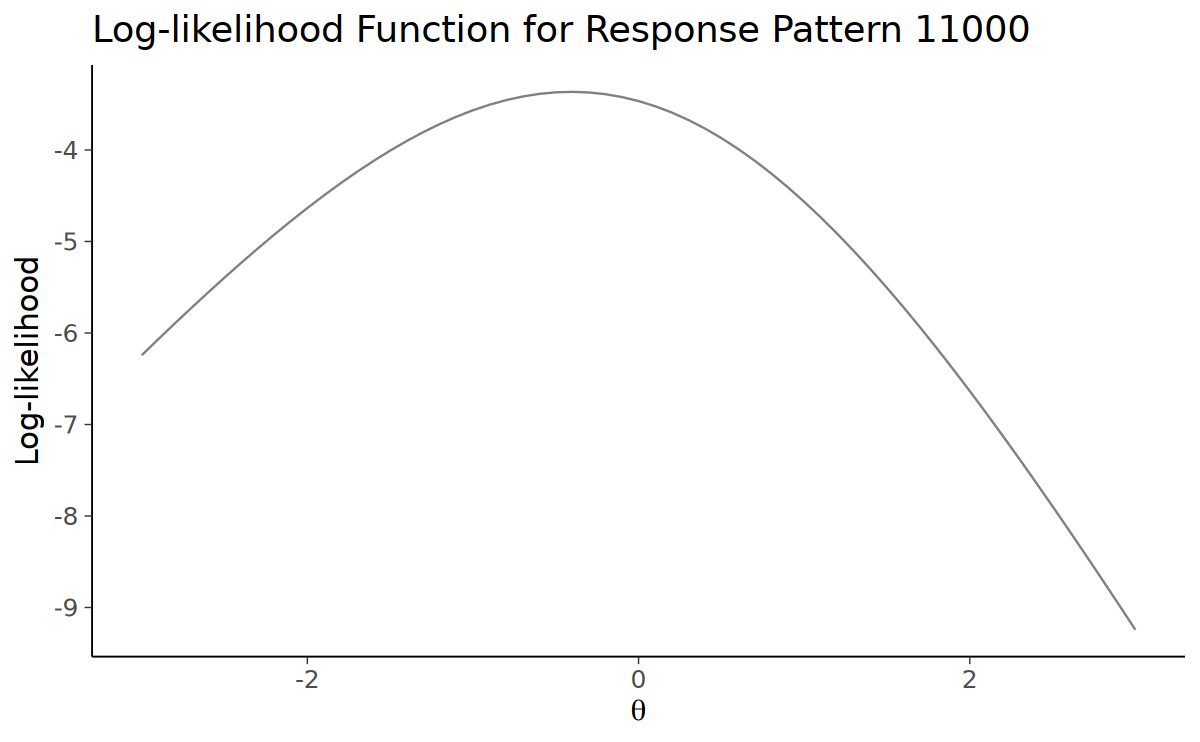

In [4]:
# Definizione del pattern di risposta
response_pattern <- c(1, 1, 0, 0, 0)

# Range di valori di theta da esplorare
theta_values <- seq(-3, 3, by = 0.1)

# Calcolo della log-verosimiglianza per ogni valore di theta
log_likelihoods <- numeric(length(theta_values))
for (i in seq_along(theta_values)) {
    theta <- theta_values[i]
    log_item_probs <- numeric(length(response_pattern))

    # Calcolo delle probabilità logaritmiche individuali per ogni item nel pattern
    for (j in seq_along(response_pattern)) {
        prob_correct <- exp(theta) / (1 + exp(theta))
        prob <- ifelse(response_pattern[j] == 1, prob_correct, 1 - prob_correct)
        log_item_probs[j] <- log(prob)
    }

    # Calcolo della log-verosimiglianza
    log_likelihoods[i] <- sum(log_item_probs)
}

# Creazione di un dataframe per il plotting
plot_data <- data.frame(theta = theta_values, log_likelihood = log_likelihoods)

# Rappresentazione grafica della log-verosimiglianza
ggplot(plot_data, aes(x = theta, y = log_likelihood)) +
    geom_line() +
    labs(
        x = expression(theta), y = "Log-likelihood",
        title = "Log-likelihood Function for Response Pattern 11000"
    ) 

:::

## Errore Standard della Stima e Informazione dell'Item

Nel modello di Rasch, l'**Errore Standard della Stima (EES)** è un indicatore chiave che quantifica l'incertezza associata alla stima del livello di abilità di un individuo ($\theta$). L'EES è fondamentale perché fornisce una misura della precisione con cui la stima di $\theta$ riflette l'abilità reale del rispondente. Un EES più basso indica una stima più precisa, mentre un EES più alto segnala una maggiore incertezza.

### Calcolo dell'EES

L'EES è determinato dall'**informazione totale dell'item** a un dato livello di abilità $\theta$, indicata con $I(\theta)$. L'EES è definito come l'inverso della radice quadrata di $I(\theta)$:

$$
\text{EES}(\theta) = \frac{1}{\sqrt{I(\theta)}},
$$

dove $I(\theta)$ rappresenta l'informazione totale accumulata dagli item del test a quel livello di abilità.


### Informazione dell'Item

L'**informazione dell'item** misura il contributo di ciascun item alla precisione della stima di $\theta$. Per un dato livello di abilità, l'informazione fornita da un singolo item dipende dalla probabilità che il rispondente dia una risposta corretta ($p_{ij}$) e dalla probabilità di una risposta errata ($1 - p_{ij}$). La formula per calcolare l'informazione totale degli item è:

$$
I(\theta) = \sum_{j=1}^{L} p_{ij}(1 - p_{ij}),
$$

dove:

- $L$ è il numero totale di item del test.
- $p_{ij}$ è la probabilità che una persona con abilità $\theta$ risponda correttamente all'item $j$.

L'informazione fornita da un singolo item raggiunge il suo massimo quando la difficoltà dell'item ($\delta_j$) è uguale al livello di abilità del rispondente ($\theta$). In questa condizione, l'item discrimina al meglio tra rispondenti con livelli di abilità leggermente superiori o inferiori a $\delta_j$.


### Relazione tra Informazione e Precisione

- **Massima informazione, minima incertezza**: Quando $I(\theta)$ è alta, l'EES ($\text{EES}(\theta)$) è basso, indicando una stima precisa.
- **Bassa informazione, alta incertezza**: Quando $I(\theta)$ è bassa, l'EES è alto, segnalando una maggiore incertezza nella stima di $\theta$.

Questa relazione evidenzia l'importanza di progettare test con item che siano informativi per il range di abilità di interesse.


### Curva di Informazione dell'Item

L'**informazione dell'item** varia a seconda del livello di abilità del rispondente. Per visualizzare questa relazione, si traccia la **curva di informazione dell'item**, che rappresenta l'informazione fornita da un singolo item in funzione di $\theta$. Alcune caratteristiche della curva:

- Ha una forma a campana.
- Raggiunge il picco quando $\theta = \delta_j$, ossia quando l'abilità del rispondente corrisponde alla difficoltà dell'item.
- Larghezza e altezza della curva dipendono dalla discriminazione dell'item (nel modello Rasch, fissata a 1).

La somma delle curve di informazione dei singoli item produce la **curva di informazione totale del test**, che mostra la precisione complessiva del test a diversi livelli di abilità.


### Applicazioni pratiche

- **Progettazione del test**: La conoscenza dell'informazione degli item aiuta a creare test che siano più informativi per specifici livelli di abilità, riducendo l'EES per i range di interesse.
- **Interpretazione dei risultati**: L'EES permette di stimare intervalli di confidenza per $\theta$, fornendo una misura della precisione della stima:

  $$
  \text{Intervallo di confidenza per } \theta = \theta \pm 1.96 \cdot \text{EES}(\theta).
  $$

L'analisi dell'informazione dell'item e del test è quindi essenziale per garantire che le misurazioni ottenute siano affidabili e utili per l'interpretazione e il confronto delle abilità.

::: {#exr-}

Utilizzando il modello di Rasch, possiamo calcolare le probabilità di risposta corretta per diversi valori di abilità e, di conseguenza, la *Funzione Informativa dell'Item* (*Item Information Function*, IIF):

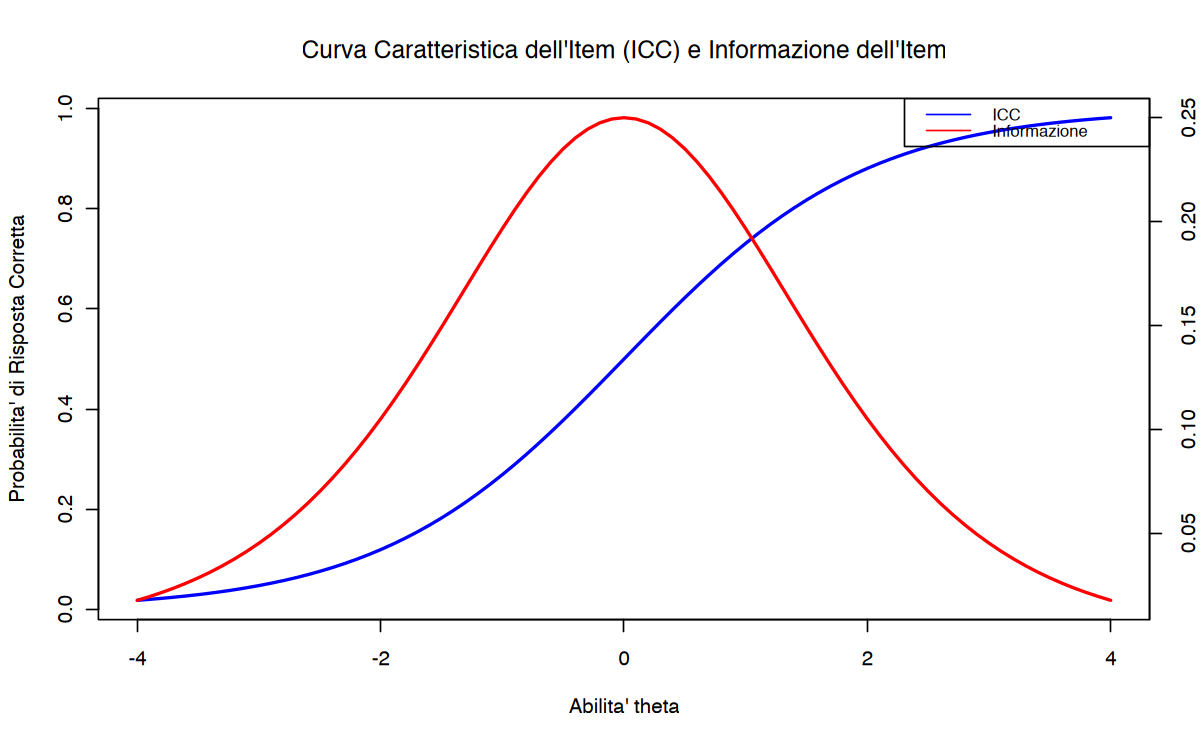

In [21]:
# Definizione di un range di abilità
theta <- seq(-4, 4, by = 0.1)

# Definizione di un parametro di difficoltà dell'item
beta <- 0

# Calcolo delle probabilità di risposta corretta per ciascun valore di abilità usando la funzione logistica
prob_correct <- exp(theta - beta) / (1 + exp(theta - beta))

# Calcolo dell'informazione dell'item
item_info <- prob_correct * (1 - prob_correct)

# Creazione della prima grafica (ICC)
plot(theta, prob_correct,
    type = "l", col = "blue", lwd = 2,
    xlab = "Abilita' theta", ylab = "Probabilita' di Risposta Corretta",
    main = "Curva Caratteristica dell'Item (ICC) e Informazione dell'Item"
)

# Aggiunta di un secondo asse y per l'informazione
par(new = TRUE)
plot(theta, item_info,
    type = "l", col = "red", lwd = 2,
    xlab = "", ylab = "", axes = FALSE, ann = FALSE
)

# Aggiungere l'asse y di destra per l'informazione
axis(side = 4, at = pretty(range(item_info)))
mtext("Informazione", side = 4, line = 3)

# Aggiunta della legenda
legend("topright",
    legend = c("ICC", "Informazione"),
    col = c("blue", "red"), lty = 1, cex = 0.8
)

Questa rappresentazione grafica in R mostra come l'informazione vari in funzione del livello di abilità. In generale, l'informazione è massima quando l'abilità dell'esaminando è vicina alla difficoltà dell'item e diminuisce man mano che ci si allontana da questo punto.

Il concetto di informazione in IRT è fondamentale sia per la costruzione del test sia per la sua interpretazione. Indica quanto efficacemente ciascun item misura l'abilità a vari livelli e aiuta a determinare quali item sono più informativi per la stima dell'abilità degli esaminandi. Inoltre, fornisce indicazioni sulla precisione con cui l'abilità degli esaminandi può essere stimata a vari punti lungo la scala di abilità.
:::

::: {#exr-}

Per dimostrare come calcolare la TIF in $\mathsf{R}$, possiamo estendere l'esempio precedente includendo più item e sommando le loro informazioni:

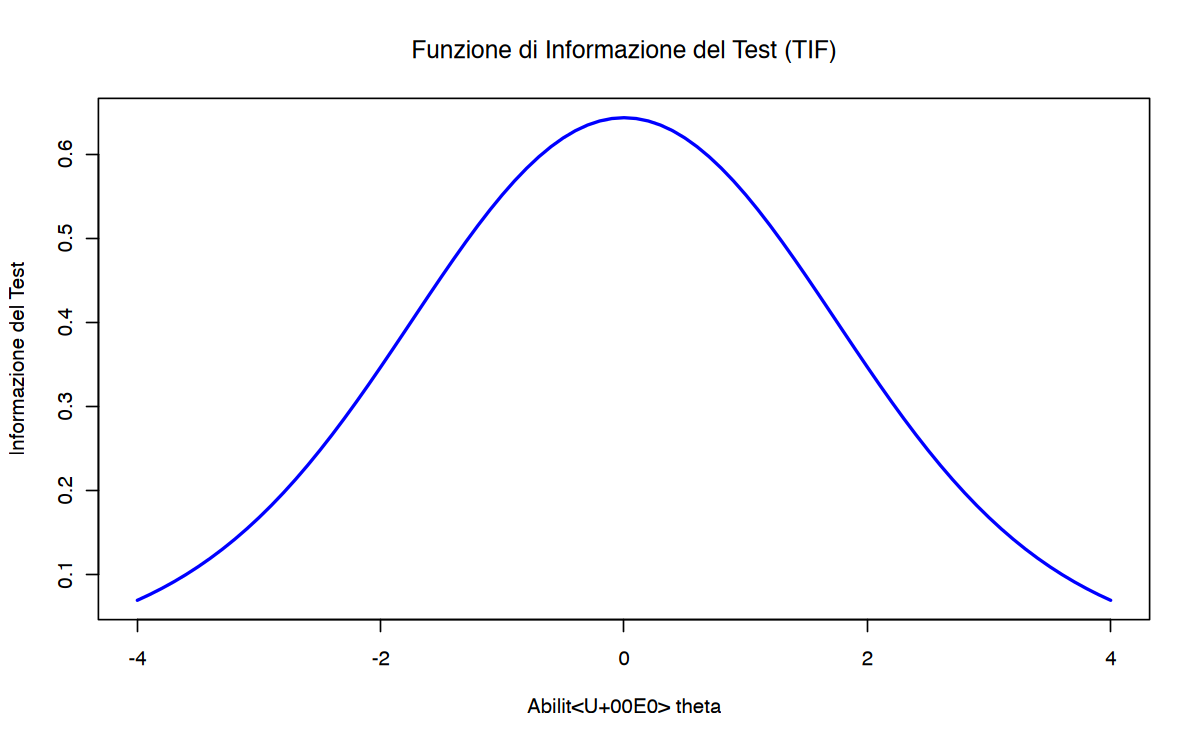

In [22]:
# Definizione di parametri di difficoltà per diversi item
beta_items <- c(-1, 0, 1) # Esempio di tre item con difficoltà diverse

# Calcolo dell'informazione per ogni item e somma per ottenere la TIF
test_info <- rep(0, length(theta))
for (beta in beta_items) {
    prob_correct <- exp(theta - beta) / (1 + exp(theta - beta))
    item_info <- prob_correct * (1 - prob_correct)
    test_info <- test_info + item_info
}

# Creazione del grafico della TIF
plot(theta, test_info,
    type = "l", col = "blue", lwd = 2,
    xlab = "Abilità theta", ylab = "Informazione del Test",
    main = "Funzione di Informazione del Test (TIF)"
)

In questo esempio, calcoliamo e sommiamo le informazioni di tre item con diverse difficoltà per visualizzare la TIF di un test ipotetico. La TIF mostra in modo chiaro come il test nel suo insieme stima l'abilità degli esaminandi a vari livelli, fornendo così indicazioni preziose sulla costruzione e sull'utilizzo ottimale del test in diversi contesti.
:::

## Stima dell'Abilità

Nel contesto dell'IRT, la stima dell'abilità di un esaminando ($\theta$) viene effettuata utilizzando metodi iterativi, come la massima verosimiglianza, che sfruttano i dati del test e i parametri degli item. Questo processo consente di stimare il livello di abilità in modo personalizzato, tenendo conto del pattern di risposte specifico di ciascun esaminando.

### Procedura di Stima dell'Abilità

1. **Punto di partenza**:
   - La stima inizia con un'ipotesi iniziale o un valore a priori per l'abilità dell'esaminando. Questo valore può essere scelto in base a considerazioni teoriche (ad esempio, $\theta = 0$, corrispondente alla media presunta dell'abilità) o determinato da informazioni preliminari.

2. **Utilizzo dei parametri degli item**:
   - I parametri noti degli item (ad esempio, difficoltà \(\beta_i\) e discriminazione \(a_i\)) vengono utilizzati per calcolare la probabilità che l'esaminando risponda correttamente a ciascun item in base al livello di abilità iniziale ipotizzato. Questa probabilità è calcolata attraverso la funzione di risposta dell'item (IRF).

3. **Iterazione per aggiustare la stima**:
   - Il livello di abilità viene aggiornato iterativamente. L'obiettivo di ogni iterazione è migliorare la corrispondenza tra le probabilità previste di risposta corretta (basate sul livello di abilità stimato) e il pattern effettivo di risposte fornite dall'esaminando.
   - Questo processo continua fino a quando le modifiche alla stima di $\theta$ diventano trascurabili, indicando che è stato raggiunto un punto di convergenza. Il risultato finale è una stima stabile e affidabile dell'abilità.

4. **Stima personalizzata**:
   - Il processo viene ripetuto per ciascun esaminando, assicurando che ogni stima di $\theta$ sia basata esclusivamente sulle sue risposte.

### Metodi alternativi di stima

- **Stima simultanea**:
   - In alternativa alla stima iterativa individuale, esistono approcci che stimano simultaneamente i livelli di abilità di tutti gli esaminandi. Questi metodi sono particolarmente utili in presenza di un ampio campione, ottimizzando il processo di calcolo.

- **Stima Bayesiana**:
   - La stima bayesiana combina i dati del test con una distribuzione a priori sull'abilità ($\theta$) per ottenere una stima posteriore. Questo approccio è particolarmente utile quando il numero di item è limitato o le risposte sono incomplete.


### Importanza della Stima dell'Abilità

La stima dell'abilità in IRT è fondamentale per due motivi principali:

1. **Valutazione personalizzata**:
   - Permette di misurare l'abilità di ciascun esaminando in maniera individualizzata, considerando le interazioni specifiche tra il rispondente e gli item. Questa personalizzazione rende la stima più accurata rispetto ai punteggi grezzi, che non tengono conto delle caratteristiche degli item.

2. **Analisi mirate**:
   - Poiché la stima dell'abilità è direttamente legata ai parametri degli item, consente di condurre analisi dettagliate sull'efficacia del test (ad esempio, quali item sono più informativi per specifici livelli di abilità) e sulle caratteristiche dei rispondenti.

In conclusione, la stima dell'abilità in IRT è un processo iterativo che utilizza i parametri degli item e il pattern di risposte individuali per fornire stime accurate e personalizzate del livello di abilità di ciascun esaminando. Grazie alla sua precisione, questa metodologia rappresenta una componente essenziale dell'IRT, sia per la valutazione degli esaminandi sia per l'ottimizzazione dei test.

## Stima Bayesiana

La stima bayesiana sta diventando un metodo sempre più popolare per stimare i parametri del modello di Rasch. Come la stima della massima verosimiglianza congiunta, la stima bayesiana stima simultaneamente sia i parametri delle persone che quelli degli item. Tuttavia, mentre la stima della massima verosimiglianza congiunta trova i valori di $\theta$ e $\beta$ massimizzando la verosimiglianza congiunta, la stima bayesiana utilizza la regola di Bayes per trovare la densità a posteriori, $f(\theta,\beta \mid u)$. 

Nel modello di Rasch, la regola di Bayes afferma che:

$$ 
f(\theta,\beta \mid u) = \frac{\text{Pr}(u \mid \theta,\beta)f(\theta,\beta)}{\text{Pr}(u)}. 
$$

Il primo termine nel numeratore, $\text{Pr}(u \mid \theta, \beta)$, è la verosimiglianza congiunta. Il secondo è la distribuzione a priori congiunta per $\theta$ e $\beta$. Il denominatore è la probabilità media dei dati osservati rispetto alla distribuzione a priori congiunta.

A differenza della stima della massima verosimiglianza, che si concentra sulla massimizzazione della verosimiglianza, la stima bayesiana integra le informazioni a priori con i dati osservati. La regola di Bayes combina la verosimiglianza dei dati osservati (la probabilità di osservare i dati dati i parametri) con la distribuzione a priori (le nostre credenze sui parametri prima di osservare i dati) per produrre una distribuzione a posteriori (le nostre credenze aggiornate sui parametri dopo aver osservato i dati). La densità a posteriori $f(\theta,\beta \mid u)$ ci fornisce una stima completa dei parametri, considerando sia i dati osservati sia le informazioni a priori.

In pratica, la stima bayesiana fornisce un approccio flessibile e informativo alla stima dei parametri nel modello di Rasch, consentendo l'integrazione di conoscenze pregresse e osservazioni attuali.

### Implementazione

Esaminiamo un'applicazione della stima Bayesiana usando il linguaggio probabilistico Stan. Il modello di Rasch è implementato nel file `rasch_model.stan` utilizzando le distribuzioni a priori specificate da @debelak2022introduction. 

In [5]:
stan_file <- "../../code/rasch_model.stan"
mod <- cmdstan_model(stan_file)
mod$print()

data {
  int<lower=1> num_person;
  int<lower=1> num_item;
  array[num_person, num_item] int<lower=0, upper=1> U;
}
parameters {
  vector[num_person] theta;
  vector[num_item] beta;
  real mu_beta;
  real<lower=0> sigma2_theta;
  real<lower=0> sigma2_beta;
}
transformed parameters {
  array[num_person, num_item] real<lower=0, upper=1> prob_solve;
  for (p in 1:num_person) 
    for (i in 1:num_item) 
      prob_solve[p, i] = inv_logit(theta[p] - beta[i]);
}
model {
  for (p in 1:num_person) 
    for (i in 1:num_item) 
      U[p, i] ~ bernoulli(prob_solve[p, i]);
  theta ~ normal(0, sqrt(sigma2_theta));
  beta ~ normal(mu_beta, sqrt(sigma2_beta));
  sigma2_theta ~ inv_chi_square(0.5);
  sigma2_beta ~ inv_chi_square(0.5);
}




Nella presente implementazione bayesiana del modello di Rasch, le sezioni "transformed parameters" e "model" hanno un ruolo centrale nel definire come i dati vengono processati e come il modello viene applicato. Vediamo dettagliatamente ciascuna sezione:

#### Sezione Transformed Parameters

Nella sezione `transformed parameters`, viene definita la trasformazione dei parametri di base (i parametri `theta` per le abilità delle persone e `beta` per la difficoltà degli item) in una probabilità di risposta corretta per ogni coppia persona-item. Qui viene usata la funzione logistica inversa per convertire la differenza tra l'abilità della persona e la difficoltà dell'item in una probabilità:

```stan
transformed parameters {
  array[num_person, num_item] real<lower=0, upper=1> prob_solve;
  for (p in 1:num_person) 
    for (i in 1:num_item) 
      prob_solve[p, i] = inv_logit(theta[p] - beta[i]);
}
```

Questa trasformazione serve a mappare la differenza tra l'abilità della persona (`theta[p]`) e la difficoltà dell'item (`beta[i]`) in un intervallo di probabilità tra 0 e 1. La funzione `inv_logit` è comunemente usata per questo scopo, essendo la funzione logistica inversa.

#### Sezione Model

Nella sezione `model`, vengono definite le distribuzioni di probabilità per i dati osservati e i parametri del modello, che sono essenziali per la stima bayesiana. Questa parte del codice descrive come i dati sono generati, supponendo il modello di Rasch:

```stan
model {
  for (p in 1:num_person) 
    for (i in 1:num_item) 
      U[p, i] ~ bernoulli(prob_solve[p, i]);
  theta ~ normal(0, sqrt(sigma2_theta));
  beta ~ normal(mu_beta, sqrt(sigma2_beta));
  sigma2_theta ~ inv_chi_square(0.5);
  sigma2_beta ~ inv_chi_square(0.5);
}
```

- `U[p, i] ~ bernoulli(prob_solve[p, i])`: ogni risposta `U[p, i]`, che indica se la persona `p` ha risposto correttamente all'item `i`, segue una distribuzione di Bernoulli dove la probabilità di successo è data da `prob_solve[p, i]`. Questa è la vera verosimiglianza del modello, che collega i dati osservati alle probabilità calcolate tramite il modello logistico.
- `theta ~ normal(0, sqrt(sigma2_theta))` e `beta ~ normal(mu_beta, sqrt(sigma2_beta))`: le distribuzioni a priori per i parametri `theta` e `beta` sono normali. Questo significa che, in assenza di dati, si assume che queste variabili si distribuiscano normalmente con una media di 0 per `theta` e `mu_beta` per `beta`, e una deviazione standard derivata dai parametri di varianza `sigma2_theta` e `sigma2_beta`.
- `sigma2_theta ~ inv_chi_square(0.5)` e `sigma2_beta ~ inv_chi_square(0.5)`: le varianze `sigma2_theta` e `sigma2_beta` hanno distribuzioni a priori che seguono una distribuzione chi quadrato inversa con parametro di forma 0.5. Questa è una scelta comune per imporre una distribuzione non informativa (vaga) sui parametri di scala.

In conclusione, la sezione `transformed parameters` calcola le probabilità di risposta corretta basate sui parametri di abilità e difficoltà, mentre la sezione `model` specifica come questi parametri e le risposte osservate interagiscono secondo il modello di Rasch, definendo così la struttura della verosimiglianza e delle priorità nel contesto bayesiano.

Compiliamo il modello usando CmdStan:

In [6]:
mod$compile()

Definiamo i dati nel formato appropriato per Stan:

In [7]:
data(data.fims.Aus.Jpn.scored, package = "TAM")
people <- 1:400
responses <- data.fims.Aus.Jpn.scored[people, 2:15]
responses <- as.matrix(sapply(responses, as.integer))
colnames(responses) <- gsub("M1PTI", "I", colnames(responses))

stan_data <- list(
    num_person = nrow(responses),
    num_item = ncol(responses),
    U = responses
)

I1,I2,I3,I6,I7,I11,I12,I14,I17,I18,I19,I21,I22,I23
1,0,1,1,0,1,0,0,1,0,0,0,0,1
0,1,1,0,0,0,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,0,0,1
1,1,1,1,0,1,1,0,0,0,0,0,0,0
1,1,1,1,0,1,0,1,0,1,0,0,0,1
1,1,1,0,0,0,0,0,0,1,0,1,0,0
0,0,1,0,0,1,1,1,1,0,0,0,0,0
1,1,0,1,0,1,0,1,0,1,0,0,0,1
0,0,1,0,0,0,0,1,0,0,0,0,1,0
0,1,1,0,0,1,0,0,0,1,0,0,1,1


Eseguiamo il campionamento MCMC per ottenere la distribuzione a posteriori dei parametri.

In [8]:
fit <- mod$sample(
    data = stan_data,
    chains = 4, # Number of MCMC chains
    parallel_chains = 2, # Number of chains to run in parallel 
    iter_warmup = 2000, # Number of warmup iterations per chain
    iter_sampling = 2000, # Number of sampling iterations per chain
    seed = 1234 # Set a seed for reproducibility
)

Running MCMC with 4 chains, at most 2 in parallel...

Chain 1 Iteration:    1 / 4000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/RtmpQ4Yx11/model-aa37440f4344.stan', line 23, column 2 to column 40)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:    1 / 4000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/RtmpQ4Yx11/model-aa37440f4344.stan', line 23, column 2 to column 40)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 1 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 2 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 1 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 1 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 2 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 1 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 2 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 1 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 2 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 1 Iteration:  600 / 4000 [ 15%]  (Warmup) 
Chain 2 Iteration:  600 / 4000 [ 15%]  (Warmup) 
Chain 1 Iteration:  700 / 4000 [ 17%]  (Warmup) 
Chain 2 Iteration:  700 / 4000 [ 17%]  (Warmup) 
Chain 1 Iteration:  800 / 4000 [ 20%]  (Warmup) 
Chain 2 Iteration:  800 / 4000 [ 20%]  (Warmup) 
Chain 1 Iteration:  900 / 4000 [ 22%]  (Warmup) 
Chain 2 Iteration:  900 / 4000 [ 22%]  (Warmup) 
Chain 1 Iteration: 1000 / 4000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 4000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/RtmpQ4Yx11/model-aa37440f4344.stan', line 23, column 2 to column 40)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 2 Iteration: 4000 / 4000 [100%]  (Sampling) 
Chain 2 finished in 20.4 seconds.
Chain 4 Iteration:    1 / 4000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 4 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 3 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 4 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 3 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 4 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 3 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 4 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 3 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 4 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 3 Iteration:  600 / 4000 [ 15%]  (Warmup) 
Chain 3 Iteration:  700 / 4000 [ 17%]  (Warmup) 
Chain 4 Iteration:  600 / 4000 [ 15%]  (Warmup) 
Chain 3 Iteration:  800 / 4000 [ 20%]  (Warmup) 
Chain 4 Iteration:  700 / 4000 [ 17%]  (Warmup) 
Chain 4 Iteration:  800 / 4000 [ 20%]  (Warmup) 
Chain 3 Iteration:  900 / 4000 [ 22%]  (Warmup) 
Chain 4 Iteration:  900 / 4000 [ 

Esaminiamo le tracce per due parametri.

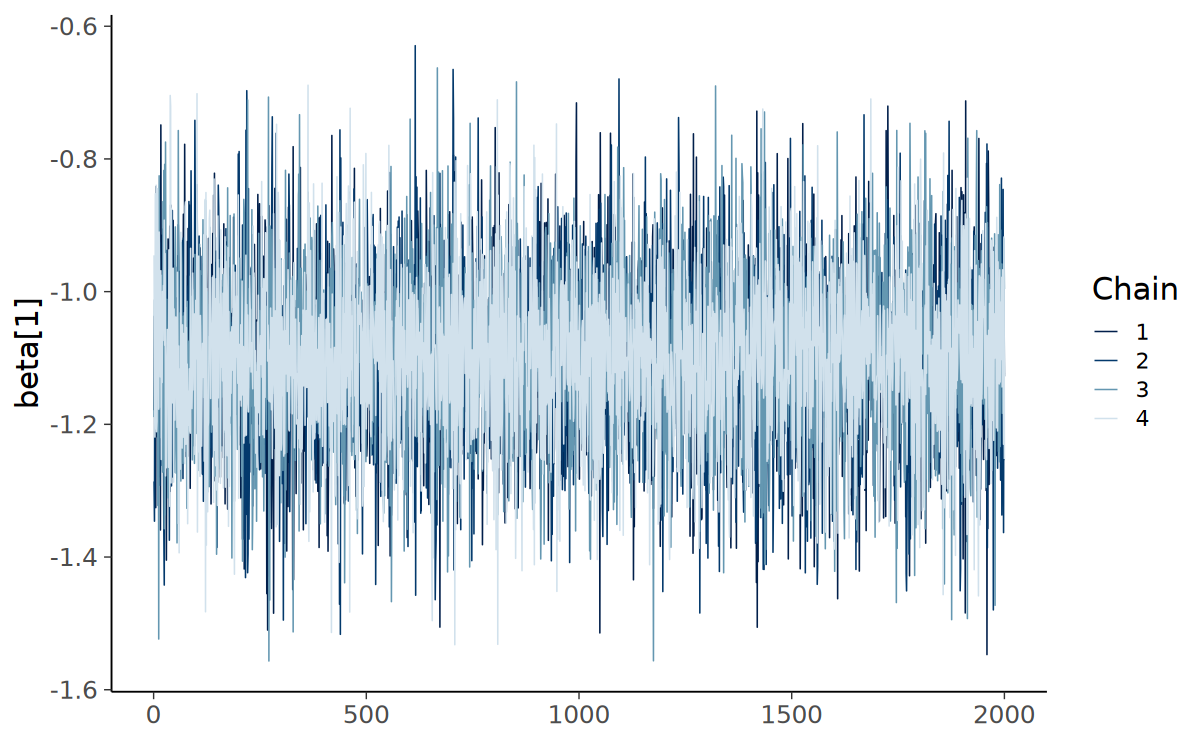

In [9]:
fit_draws <- fit$draws() # extract the posterior draws
mcmc_trace(fit_draws, pars = c("beta[1]"))

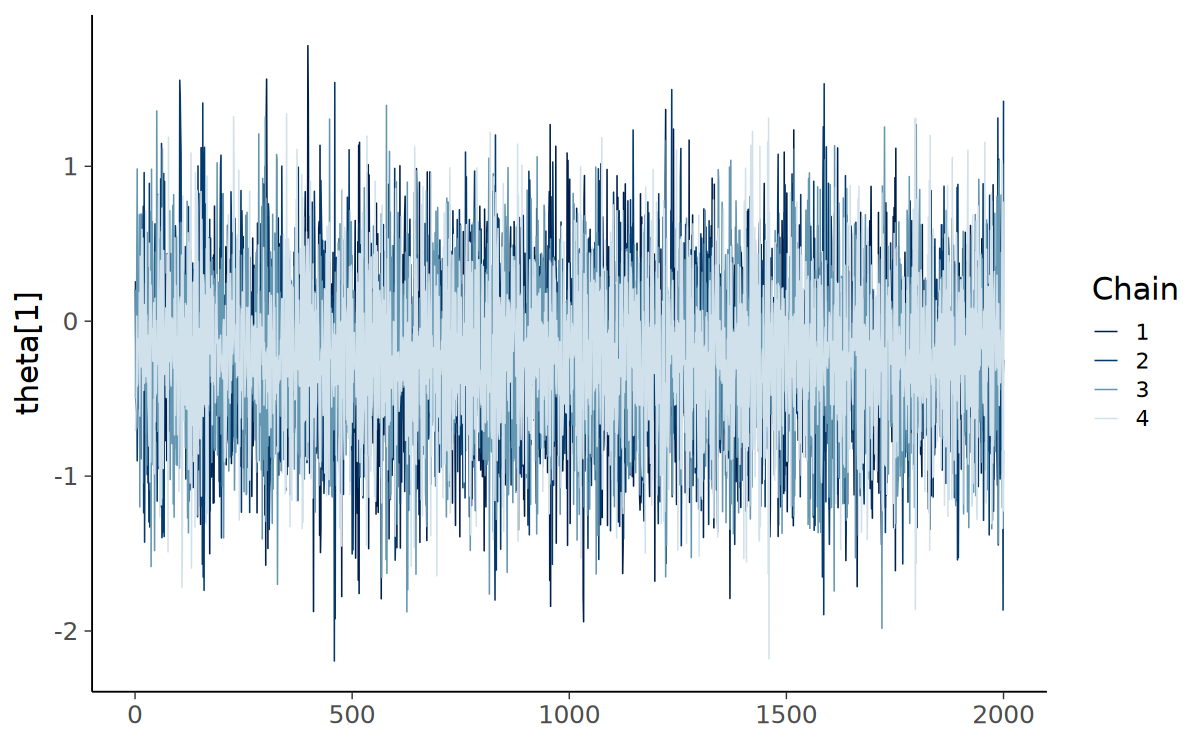

In [10]:
mcmc_trace(fit_draws, pars = c("theta[1]"))

Focalizziamoci sulla stima dei parametri degli item.

In [ ]:
parameters <- c(
    "beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]",
    "beta[6]", "beta[7]", "beta[8]", "beta[9]","beta[10]",
    "beta[11]", "beta[12]", "beta[13]", "beta[14]"
)

Esaminiamo la statistica rhat.

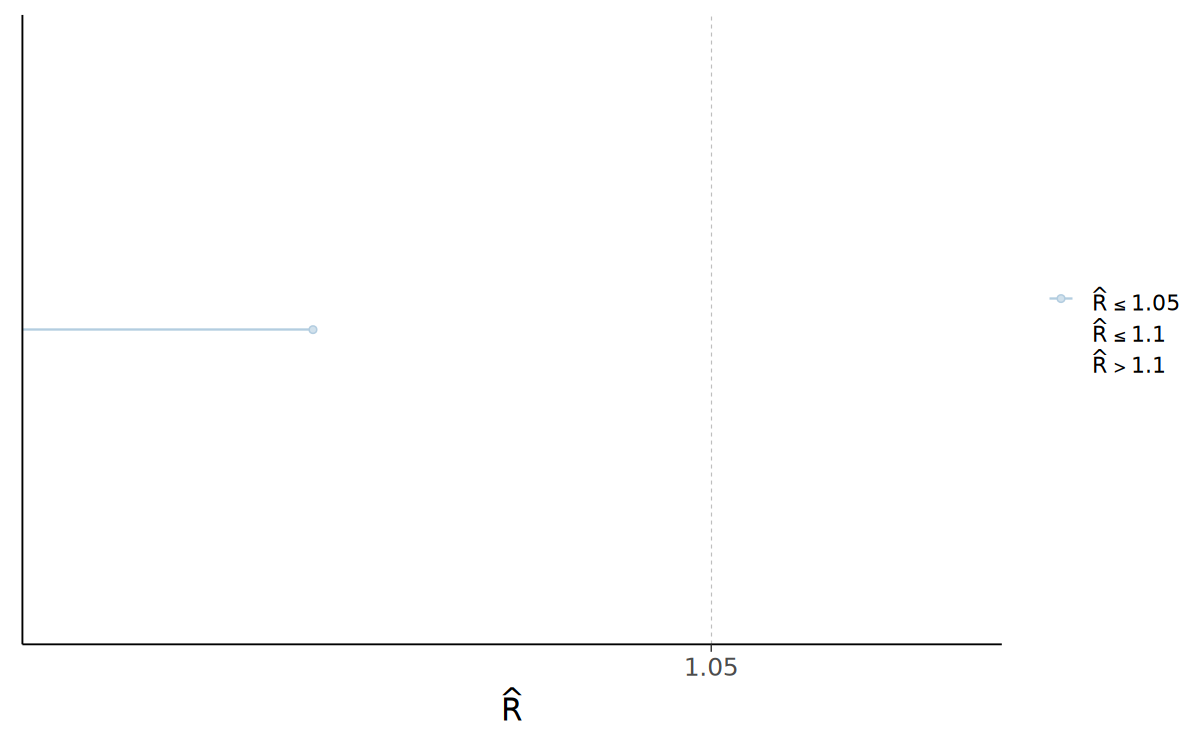

In [12]:
rhats <- rhat(fit_draws, pars = parameters)
mcmc_rhat(rhats)

Esaminiamo l'effect ratio:

In [14]:
eff_ratio <- neff_ratio(fit, pars = parameters)
eff_ratio 

beta[1]  beta[2]  beta[3]  beta[4]  beta[5]  beta[6]  beta[7]  beta[8] 
    1.13     1.19     1.16     1.10     1.36     1.16     1.18     1.08 
 beta[9] beta[10] beta[11] beta[12] beta[13] beta[14] 
    1.30     1.21     1.26     1.23     1.39     1.31

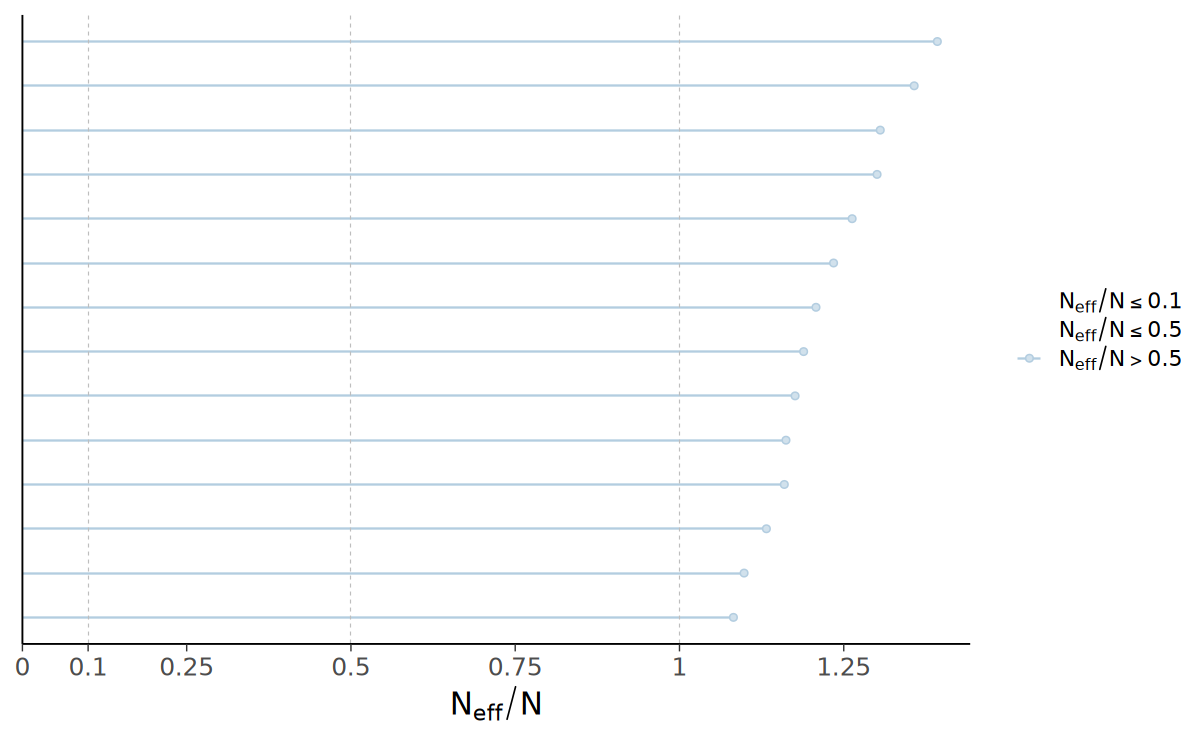

In [15]:
mcmc_neff(eff_ratio)

Esaminiamo l'autocorrelazione.

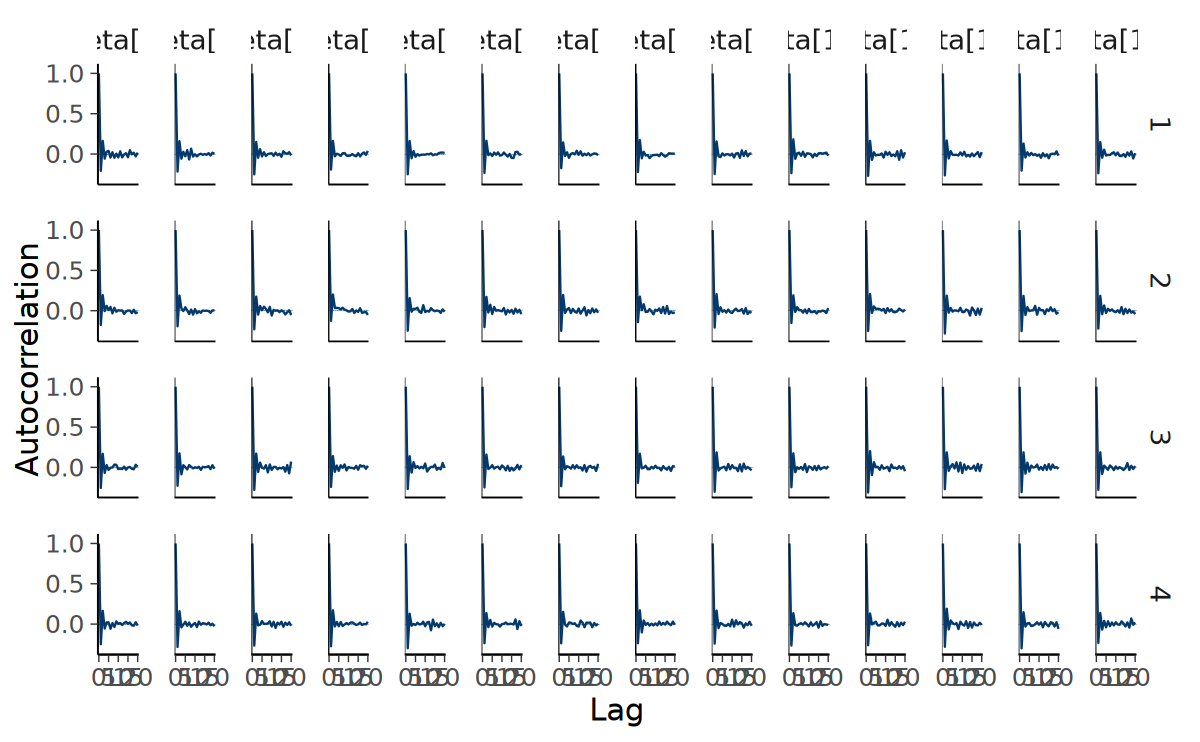

In [16]:
mcmc_acf(fit_draws, pars = parameters)

Otteniamo le statistiche riassuntive delle distribuzioni a posteriori dei parametri degli item.

In [17]:
fit$summary(
    variables = parameters,
    posterior::default_summary_measures(),
    extra_quantiles = ~ posterior::quantile2(., probs = c(.0275, .975))
)

variable,mean,median,sd,mad,q5,q95,q2.75,q97.5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
beta[1],-1.0979,-1.0981,0.129,0.126,-1.311,-0.892,-1.351,-0.849
beta[2],-1.2447,-1.2443,0.130,0.130,-1.458,-1.033,-1.496,-0.997
beta[3],-2.0287,-2.0246,0.158,0.156,-2.295,-1.769,-2.337,-1.729
beta[4],-0.0478,-0.0489,0.120,0.121,-0.241,0.149,-0.274,0.191
beta[5],2.5117,2.5087,0.183,0.185,2.219,2.819,2.176,2.885
beta[6],-1.2447,-1.2440,0.132,0.131,-1.463,-1.029,-1.505,-0.989
beta[7],0.8112,0.8099,0.124,0.124,0.610,1.013,0.576,1.055
beta[8],-0.4933,-0.4928,0.120,0.119,-0.688,-0.294,-0.723,-0.263
beta[9],1.3228,1.3214,0.135,0.138,1.107,1.546,1.071,1.583


I risultati ottenuti replicano quelli riportati da @debelak2022introduction.

## Grandezza del Campione

La stima dei parametri degli item basata su un campione osservato di risposte è spesso definita come la *calibrazione degli item*. Generalmente, un campione di calibrazione più ampio consente una stima più accurata dei parametri degli item, sebbene altri fattori influenzino anch'essi l'accuratezza della stima. Ad esempio, la difficoltà di un item può essere stimata con maggiore precisione se l'item non è né troppo facile né troppo difficile per il campione di partecipanti al test. Pertanto, i fattori che influenzano l'accuratezza della stima includono l'allineamento e la forma delle distribuzioni dei parametri degli item e delle persone, il numero di item e la tecnica di stima utilizzata.

Diverse pubblicazioni hanno affrontato la questione della dimensione del campione tipicamente necessaria per lavorare con il modello di Rasch e come questa sia influenzata da questi e altri fattori. Ad esempio, De Ayala (2009) fornisce la linea guida generale che un campione di calibrazione dovrebbe contenere almeno diverse centinaia di rispondenti e cita, tra le altre referenze, un articolo precedente di Wright (1977) che afferma che un campione di calibrazione di 500 sarebbe più che adeguato. De Ayala (2009) suggerisce anche che 250 o più rispondenti sono necessari per adattare un modello di Partial Credit. Poiché il modello di Partial Credit è una generalizzazione del modello di Rasch con più parametri degli item, ciò implica che la dimensione del campione suggerita di 250 dovrebbe essere sufficiente anche per adattare un modello di Rasch. Studi più recenti hanno indagato l'applicazione del modello di Rasch con dimensioni del campione di soli 100 rispondenti (ad esempio, Steinfeld & Robitzsch, 2021; Suárez-Falcón & Glas, 2003). Tali linee guida non devono essere interpretate come regole fisse, ma solo come indicazioni generali in quanto una dimensione del campione adeguata dipende dalle condizioni e dagli obiettivi dell'analisi.

Un metodo più elaborato per determinare la dimensione del campione necessaria è l'analisi della potenza statistica. Qui, l'accuratezza della stima desiderata o il rischio di falsi positivi e falsi negativi devono essere formalizzati prima dell'analisi. La dimensione del campione necessaria viene quindi determinata in base a queste considerazioni. 

## Session Info

In [20]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: aarch64-apple-darwin20
Running under: macOS Sequoia 15.1.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] effectsize_0.8.9    rsvg_2.6.1          rstan_2.32.6       
 [4] StanHeaders_2.32.10 posterior_1.6.0     cmdstanr_0.8.1.9000
 [7] ggmirt_0.1.0        TAM_4.2-21          CDM_8.2-6          
[10] mvtnorm_1.3-2       mirt_1.43           lattice_0.22-6     
[13] latex2exp_0.9.6     MASS_7.3-61         viridis_0.6.5      
[16] viridisLite_0.4.2   ggpubr_0.6.0        ggExtra_0.10.1     
[19] gridExtra_2.3       patchwork_1.3.0     bayesplot_1.11.1   
[22]